# Introduction
We have received finance data about stocks opening, closing prices and other 15 features on which prices are dependent. We'll try to fit various models to this data to check whether returns are positive or not. We have tried 2 versions of Dense Net and 2 versions of LSTMs for predicting whether returns are positive or not.

In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import copy

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, f_regression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import xgboost as xgb

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 3)
np.set_printoptions(precision=3)

%matplotlib inline

Using TensorFlow backend.


# Loading & Cleaning Data
Loading data involved loading data from CSV file wheareas cleaning data refers to handling of NAs. We also have introduced new columns like returns which is percentage change in closing price and label which is 1 if return is positive else 0.

In [2]:
data=pd.read_csv('/kaggle/input/input_data.csv')
data['Time'] = pd.to_datetime(data['Time'].values, format='%m/%d/%Y')
data = data.set_index('Time')
## Calculate % Change of Closing Price
#data['ret_final']=(data['Close'].shift(-1)-data['Close'])/data['Close']
data['ret_final'] = data.Close.pct_change()
data['label'] = [(1 if j>0 else 0) for j in data.ret_final]
data = data.fillna(0)
data.head()

,Open,High,Low,Close,Volume,feature1,feature2,feature3,feature4,feature5,...,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,ret_final,label
Time,,,,,,,,,,,,,,,,,,,,,
2008-10-15,14.83,15.29,13.98,13.99,387619900,0.0,-0.641,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0
2008-10-16,14.25,14.86,13.11,14.56,480128000,0.0,0.177,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041,1
2008-10-17,14.21,14.58,13.86,13.91,433964800,0.0,-0.417,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.045,0
2008-10-20,14.26,14.29,13.38,14.06,383539500,0.0,-0.220,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011,1
2008-10-21,13.86,13.99,13.00,13.07,446705000,0.0,-0.798,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.070,0


## P-value For Label, Returns and Close Price
Below we have plotted p-value and f-classif/f-regression values. Lower p-values generally indicates that that feature has high relation with target variable. Higher p-values incdicates that feature has less relation with target. You can compare this graph with above one.

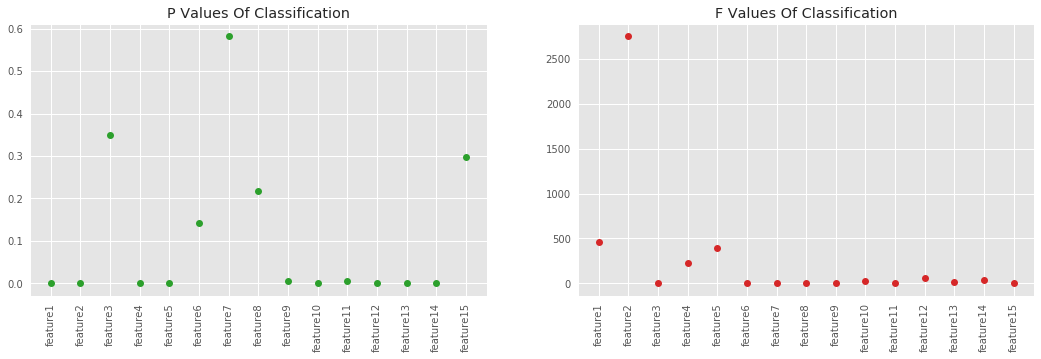

In [3]:
X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']]
X = MinMaxScaler().fit_transform(X)
Y = data['label'].values

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(18,5))
    plt.subplot(121)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), ['feature' +str(i) for i in range(1, X.shape[1]+1)], rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(122)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), ['feature' +str(i) for i in range(1, X.shape[1]+1)], rotation='vertical')
    plt.title('F Values Of Classification');

# Dividing Data Into Train/Test Sets
We have selected 15 features are our main features for prediction and label column as predicting column. We'll divide dataset into `90%` for training and `10%` for test.

In [4]:
X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']]
X = MinMaxScaler().fit_transform(X)
Y = data['label'].values
ret_vals = data['ret_final'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1, shuffle=False)

actual_rets_test = ret_vals[X_train.shape[0]:]

print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Actual Return Sizes : ', actual_rets_test.shape)

Train/Test Sizes :  (2480, 15) (276, 15) (2480,) (276,)
Actual Return Sizes :  (276,)


### Visualisation Generic Functions
Below we have designed 2 function which will help up print various results.

1. `plot_confusion_matrix` - Plots confusion matrix given actual values and predictions
2. `plot_loss_and_accuracy` - Plots train/val loss and train/val accuracy for classification task and train/val MSE for regression task.

In [5]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(Y_test, preds)
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.xticks(range(2), range(2), rotation='vertical')
        plt.yticks(range(2), range(2))
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')

# XGB Booster

## Fitting Model

In [6]:
dtotal = xgb.DMatrix(data=X, label=Y)
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
dtest = xgb.DMatrix(data=X_test, label=Y_test)

params = {
    'n_estimators':200,
    'verbosity':1,
    'max_depth': 10,
    'eta': 0.3,
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': len(set(Y)),
}
num_round = 20 
bst = xgb.train(params, dtrain, num_round)

## Performance Evaluation on Test Data

In [7]:
predictions = bst.predict(dtest)
predictions = np.asarray([np.argmax(line) for line in predictions])
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.844


In [8]:
predictions_full = bst.predict(dtotal)
predictions_full = np.asarray([np.argmax(line) for line in predictions_full])
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.984


In [9]:
probs = bst.predict(dtotal)
#print(softmax_vals[:,i].shape)
df1 = copy.deepcopy(data)
df1['Preds'] = predictions_full
for col in ['0','1']:
    df1[col + '_probs'] = probs[:,int(col)]

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       127
           1       0.87      0.84      0.85       149

    accuracy                           0.84       276
   macro avg       0.84      0.84      0.84       276
weighted avg       0.85      0.84      0.84       276

Confusion Matrix : 
 [[108  19]
 [ 24 125]]


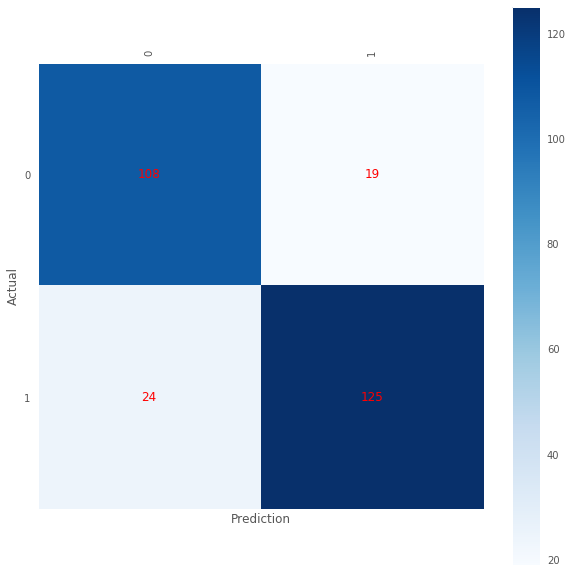

In [10]:
results = []
def print_plot_metrics(model_name, actual_rets_test, Y_test, predictions):
    print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', confusion_matrix(Y_test, predictions))
    plot_confusion_matrix(Y_test, predictions)

print_plot_metrics('XGBClassifier', actual_rets_test, Y_test, predictions)

# XGB Classifier

In [11]:
xgb_classif = xgb.XGBRFClassifier(n_estimators=500, max_depth=5, objective='binary:logistic', verbosity=1)

## Fitting Model

In [12]:
xgb_classif.fit(X_train, Y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=None, subsample=0.8, verbosity=1)

## Performance Evaluation on Test Data

In [13]:
predictions = xgb_classif.predict(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.826


In [14]:
predictions_full = xgb_classif.predict(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.863


In [15]:
probs = xgb_classif.predict_proba(X)
#print(softmax_vals[:,i].shape)
df2 = copy.deepcopy(data)
df2['Preds'] = predictions_full
for col in ['0','1']:
    df2[col + '_probs'] = probs[:,int(col)]

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.82      0.81       127
           1       0.84      0.83      0.84       149

    accuracy                           0.83       276
   macro avg       0.82      0.83      0.83       276
weighted avg       0.83      0.83      0.83       276

Confusion Matrix : 
 [[104  23]
 [ 25 124]]


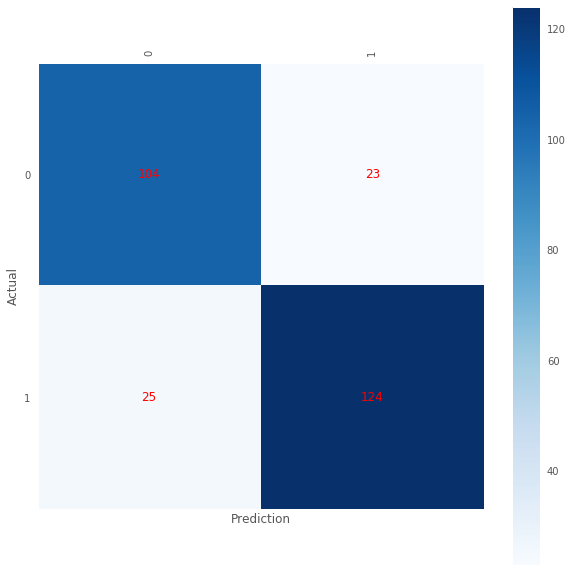

In [16]:
print_plot_metrics('XGB', actual_rets_test, Y_test, predictions)

# XGB RF Classifier

In [17]:
xgb_rfclassif = xgb.XGBRFClassifier(n_estimators=250, max_depth=15, objective='binary:logistic', verbosity=1)

## Fitting Model

In [18]:
xgb_rfclassif.fit(X_train, Y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=15, min_child_weight=1, missing=None,
                n_estimators=250, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

## Performance Evaluation on Test Data

In [19]:
predictions = xgb_rfclassif.predict(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.819


In [20]:
predictions_full = xgb_rfclassif.predict(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.930


In [21]:
probs = xgb_rfclassif.predict_proba(X)
#print(softmax_vals[:,i].shape)
df3 = copy.deepcopy(data)
df3['Preds'] = predictions_full
for col in ['0','1']:
    df3[col + '_probs'] = probs[:,int(col)]

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       127
           1       0.85      0.81      0.83       149

    accuracy                           0.82       276
   macro avg       0.82      0.82      0.82       276
weighted avg       0.82      0.82      0.82       276

Confusion Matrix : 
 [[106  21]
 [ 29 120]]


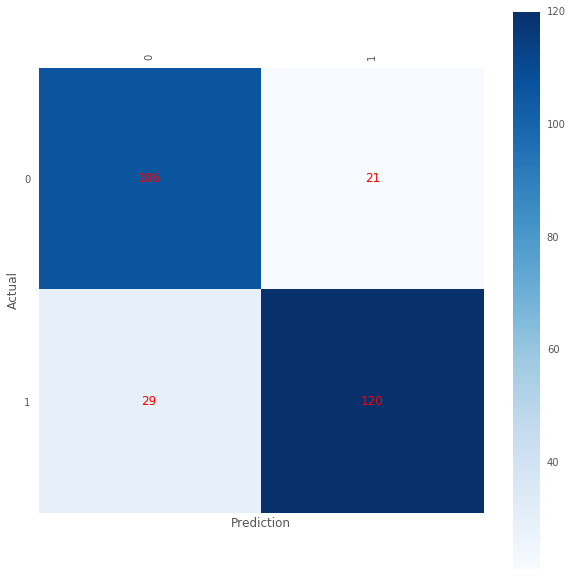

In [22]:
print_plot_metrics('XGBRFClassifier', actual_rets_test, Y_test, predictions)

In [23]:
with pd.ExcelWriter('Final_Output.xlsx') as writer:
    for sheet_name, df in [('XGB',df1), ('XGBClassifier',df2), ('XGBRFClassifier',df3)]:
        df.to_excel(writer, sheet_name= sheet_name)

In [24]:
from IPython.display import FileLink
FileLink('Final_Output.xlsx')

/kaggle/working/Final_Output.xlsx